<a href="https://colab.research.google.com/github/660510762-Chidsanupong/660510762-Chidsanupong/blob/main/Lab10_CNNs_660510762.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

## 660510762 ชิษณุพงศ์

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We will use a dataset of pizza, stead and sushi images ([source](https://donlapark.pages.dev/229352/pizza_steak_sushi.zip))

In [14]:
!unzip -q /content/pizza_steak_sushi.zip

# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

In [15]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

--2025-09-20 13:58:45--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2025-09-20 13:58:45--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip.1’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.04s   

2025-09-20 13:58:46 (383 MB/s) - ‘pizza

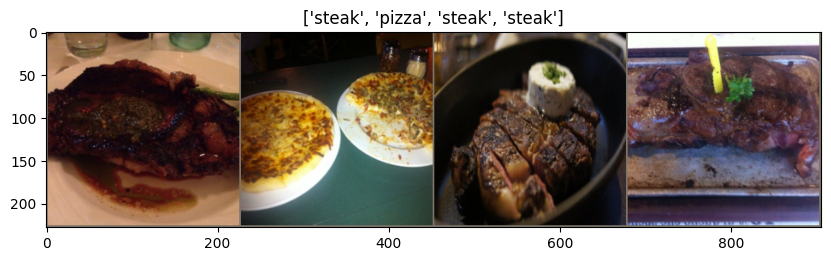

In [17]:
# 1. Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize pixel values (ImageNet statistics)
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.4)
])

# 2. Create datasets using ImageFolder
train_data = datasets.ImageFolder(root="train",
                                  transform=data_transforms)
test_data = datasets.ImageFolder(root="test",
                                 transform=data_transforms)

# 3. Create DataLoaders
BATCH_SIZE = 32 # You can experiment with different batch sizes

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's visualize a sample image and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo normalization
    inp = np.clip(inp, 0, 1) # Clip pixel values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [18]:
class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 53 * 53, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)  # flatten all except batch dim
        x = self.classifier(x)
        return x

In [19]:
lenet_model = LeNet(num_classes=3).to(device)

lenet_model

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=44944, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=3, bias=True)
  )
)

In [24]:
# Training loop function (to be reused)
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    print(f"\n--- Training {model.__class__.__name__} for {num_epochs} epochs ---")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Training phase
        model.train() # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            # Write your code here
            # 1. Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            # 2. Zero the gradient
            optimizer.zero_grad()

            # 3. Make predictions
            outputs = model(inputs)

            # 4. Calculate the loss
            loss = criterion(outputs, labels)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update model's parameters
            optimizer.step()

            # Calculate total loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_acc = train_correct / train_total
        results["train_loss"].append(epoch_train_loss)
        results["train_acc"].append(epoch_train_acc)

        # Evaluation phase
        model.eval() # Set model to evaluation mode
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad(): # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_dataloader.dataset)
        epoch_test_acc = test_correct / test_total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")
    return results

In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [26]:
# Train the LeNet model
lenet_results = train_model(lenet_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10)


--- Training LeNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.0564, Train Acc: 0.4533 | Test Loss: 1.1003, Test Acc: 0.4800
Epoch 2/10 - Train Loss: 0.8852, Train Acc: 0.5956 | Test Loss: 1.0091, Test Acc: 0.4667
Epoch 3/10 - Train Loss: 0.7378, Train Acc: 0.6978 | Test Loss: 1.7652, Test Acc: 0.4133
Epoch 4/10 - Train Loss: 0.8228, Train Acc: 0.6667 | Test Loss: 0.9709, Test Acc: 0.5200
Epoch 5/10 - Train Loss: 0.5810, Train Acc: 0.7778 | Test Loss: 0.9825, Test Acc: 0.4133
Epoch 6/10 - Train Loss: 0.5053, Train Acc: 0.8089 | Test Loss: 1.3247, Test Acc: 0.4933
Epoch 7/10 - Train Loss: 0.7225, Train Acc: 0.7067 | Test Loss: 1.0608, Test Acc: 0.5333
Epoch 8/10 - Train Loss: 0.6274, Train Acc: 0.7644 | Test Loss: 1.1809, Test Acc: 0.4933
Epoch 9/10 - Train Loss: 0.4425, Train Acc: 0.8533 | Test Loss: 1.1653, Test Acc: 0.4933
Epoch 10/10 - Train Loss: 0.2545, Train Acc: 0.9156 | Test Loss: 1.3020, Test Acc: 0.5200


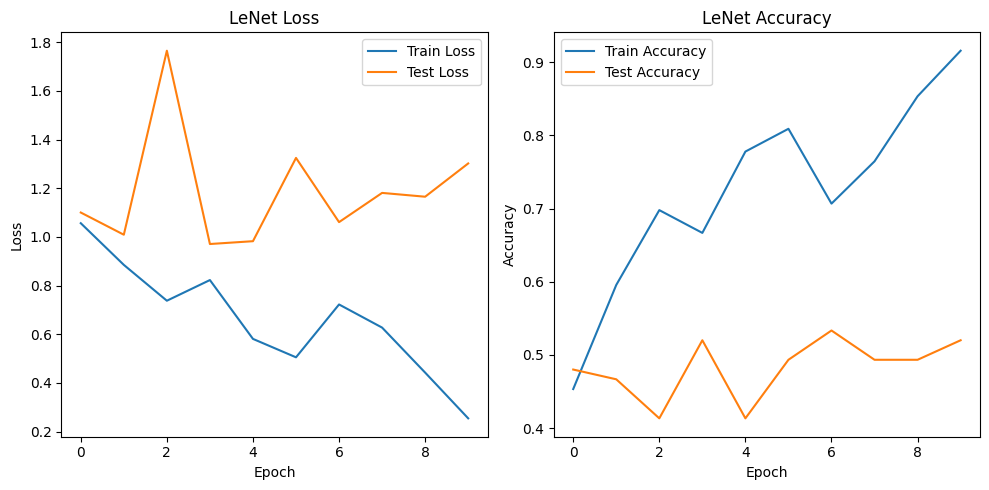

In [28]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 1:
1.  How did the LeNet model perform on the test set? What was its final test accuracy?
    *   **Your Answer:**

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [29]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 73.5MB/s]


In [30]:
efficientnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [31]:
# 2. Freeze all parameters in the feature extractor part
for param in efficientnet_model.features.parameters():
    param.requires_grad = False


# 3 Change the head (the classifier) of the model


efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)


Modified EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [32]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
classifier.1.weight
classifier.1.bias


In [33]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = torch.optim.Adam(efficientnet_model.classifier.parameters(), lr=0.001)

In [34]:
# 5. Train the transfer learning model
efficientnet_results = train_model(efficientnet_model, train_dataloader, test_dataloader, criterion_tl, optimizer_tl, num_epochs=10)


--- Training EfficientNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 6.7432, Train Acc: 0.0089 | Test Loss: 6.0651, Test Acc: 0.0133
Epoch 2/10 - Train Loss: 4.3756, Train Acc: 0.1600 | Test Loss: 3.3169, Test Acc: 0.1600
Epoch 3/10 - Train Loss: 2.7554, Train Acc: 0.2711 | Test Loss: 2.4635, Test Acc: 0.2400
Epoch 4/10 - Train Loss: 2.0589, Train Acc: 0.3333 | Test Loss: 2.1461, Test Acc: 0.2667
Epoch 5/10 - Train Loss: 1.6864, Train Acc: 0.4444 | Test Loss: 1.7790, Test Acc: 0.4267
Epoch 6/10 - Train Loss: 1.4978, Train Acc: 0.4400 | Test Loss: 1.6543, Test Acc: 0.4800
Epoch 7/10 - Train Loss: 1.2719, Train Acc: 0.5556 | Test Loss: 1.5739, Test Acc: 0.5067
Epoch 8/10 - Train Loss: 1.1432, Train Acc: 0.6578 | Test Loss: 1.4335, Test Acc: 0.5733
Epoch 9/10 - Train Loss: 0.8915, Train Acc: 0.7289 | Test Loss: 1.4759, Test Acc: 0.5467
Epoch 10/10 - Train Loss: 0.8979, Train Acc: 0.7289 | Test Loss: 1.1508, Test Acc: 0.5600


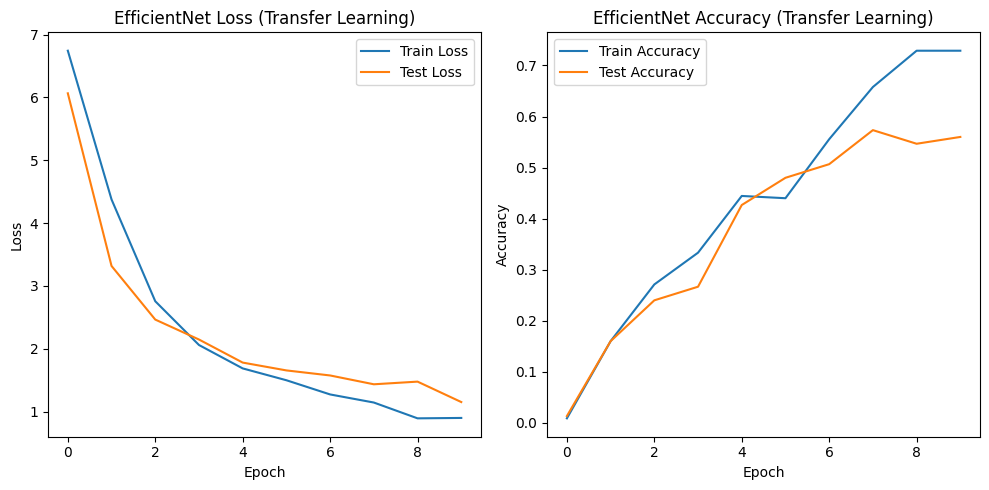

In [35]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1.  Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
    *   **Your Answer:** "จากการทดลองเปรียบเทียบ พบว่า EfficientNet_B0 ให้ผลการทดสอบดีกว่า LeNet อย่างชัดเจน ทั้งในแง่ของความแม่นยำและความสามารถในการ generalize ไปยังข้อมูลใหม่ สาเหตุหลักเพราะ EfficientNet เป็นโมเดลที่ผ่านการ pretrain บน dataset ขนาดใหญ่อย่าง ImageNet ทำให้สามารถดึงคุณลักษณะของภาพได้ดีกว่าการ train LeNet จากศูนย์ ในขณะที่ LeNet มีโครงสร้างที่ค่อนข้างเก่าและไม่เหมาะกับภาพที่มีความซับซ้อนสูงและขนาดใหญ่ ดังนั้น transfer learning จึงช่วยให้ประหยัดทั้งเวลาและได้ผลลัพธ์ที่ดีกว่า"
2.  Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
    *   **Your Answer:** "การ freeze คือไม่ให้ weight ของบางเลเยอร์อัปเดต เพื่อเก็บ feature เดิมจาก ImageNet ช่วย train เร็วขึ้น และลด overfitting"
3.  What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
    *   **Your Answer:** "เมื่อใช้ transfer learning กับ dataset ที่แตกต่างจาก ImageNet มาก เช่น medical images อาจเกิดปัญหา **feature mismatch** และ **domain shift** ทำให้โมเดลไม่สามารถดึงคุณลักษณะได้ดีเหมือนเดิม ส่งผลให้ประสิทธิภาพลดลง จำเป็นต้อง fine-tune โมเดลเพิ่มหรือใช้ pretrain จาก dataset ที่ใกล้เคียงกับ domain นั้นแทน"
4.  Choose 3 images from the test set. Display the images and show their predicted classes.

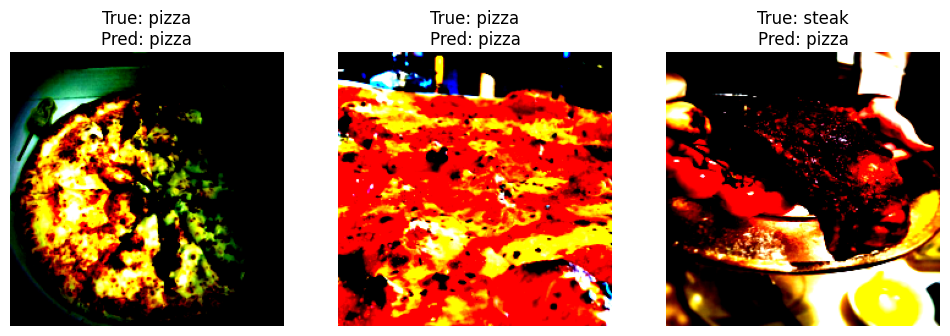

In [39]:
import random

indices = random.sample(range(len(test_data)), 3)

efficientnet_model.eval()
plt.figure(figsize=(12, 4))

for i, idx in enumerate(indices):
    img, label = test_data[idx]
    plt.subplot(1, 3, i+1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    with torch.no_grad():
        pred = efficientnet_model(img.unsqueeze(0).to(device))
        predicted_class = class_names[torch.argmax(pred).item()]
    plt.title(f"True: {class_names[label]}\nPred: {predicted_class}")
    plt.axis("off")

plt.show()

In [40]:
# Example of making prediction on an image

x = torch.rand(1, 3, 224, 224)  # an image

prediction = efficientnet_model(x.to(device))

torch.argmax(prediction)

tensor(756, device='cuda:0')

$$ P(y=0 | x) = \frac{e^{0.1164}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=1 | x) = \frac{e^{-0.0953}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=2 | x) = \frac{e^{0.0978}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$